In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class OceanHelper:
    def __init__(self, ocean_dir, x_template):
        self.ocean_dir = ocean_dir
        self.x_template = ocean_dir + x_template
        self.var_start = 29
        self.output_start = 46
        self.param_names = ["Ln", "Lp", "Wn", "Wp", "Vbias"]
        self.param_sufixes = ["n", "n", "n", "n", ""]
            
    def create_population(self, n):
        f = open(self.ocean_dir + "population.ocn", "w")
        
        with open(self.x_template, 'r') as file:
            data = file.readlines()
        
        for i in range(0, n):
            f.write("load(\"" + self.ocean_dir + "x_" + str(i) + ".ocn\")\n")
            
            filename = self.ocean_dir + "x_" + str(i) + ".ocn"
            
            new_data = data.copy()
            
            for j in range(0, len(data)):
                new_data[j] = new_data[j].replace("_n.txt", "_" + str(i) + ".txt")

            with open(filename, 'w') as file:
                file.writelines( new_data )
        
        f.write("exit()")
        f.close()
    
    # Ordem dos parametros:
    # params = [Ln, Lp, Wn, Wp, Vbias]
    def update_x(self, params, n):
        filename = self.ocean_dir + "x_" + str(n) + ".ocn"
        with open(filename, 'r') as file:
            data = file.readlines()
        
        for i in range(0, len(self.param_names)):
            data[i+self.var_start] = "desVar( \"" + self.param_names[i]  + "\" " + str(params[i]) + self.param_sufixes[i] + " )\n"
        
        with open(filename, 'w') as file:
            file.writelines( data )
    
    def eng2num(self, eng):
        symbol_table = ['a', 'p', 'n', 'u', 'm', '','k']
        last_char = eng[-1]
        eng_len = len(eng)
        
        if last_char.isnumeric():
            last_char = ''
            eng_len += 1
            
        power = -15 + 3*symbol_table.index(last_char)
        
        return float(eng[0:eng_len-1])*10**power
        
        
    def read_response(self, waveform, n):
        wave_data_str = np.loadtxt("./SimulationOutputs/" + waveform + "_" + str(n) + ".txt", skiprows=3, dtype=str)
#         print(wave_data_str)
        wave_data_float = np.zeros(wave_data_str.size)
        vec_eng2num = np.vectorize(self.eng2num)
        wave_data_float = vec_eng2num(wave_data_str)
        
        return wave_data_float
    
    def simulate_all(self):
        os.system("ocean -restore " + self.ocean_dir + "population.ocn")
        
    def compute_fitness(self, n, target):
        vout = OH.read_response("vout", 1)
        vin = OH.read_response("vin", 1)
        target_wave = (vin[:, 1] > target)*1.8
        rmse = np.sqrt(np.mean((vout[:,0] - target_wave)**2))
        return 1/rmse
        
        

In [3]:
#Simple Genetic Algorithm

#Xs: individuos
#gens: gerações
#k: numero de melhores individuos que poderão ser pais
#mu: numero de individuos por geração
#max_inc: valores máximos de incremento na mutação
#target: tensão de limiar alvo do comparador
#n_params: numero de parametros que cada indivíduo representa
#limits: valores limite para os parâmetros
#mut_rate: taxa de mutação

def SGA (OH, Xs, gens, k, mu, max_inc, target, n_params, limits, mut_rate):
    
    # Declaração dos vetores que seão utilizados em todas as gerações para evitar
    # re-alocar memória a cada iteração do loop (faz mais diferença quando o tempo de execução
    # não é dominado pela função custo)
    
    # k melhores individuos, possíveis pais
    parents = np.zeros((k, n_params+1))
    
    # Dupla de pais utilzada na mutação
    p1 = np.zeros((n_params+1,))
    p2 = np.zeros((n_params+1,))
    
    # Melhor Indivíduo
    bestX = np.zeros((n_params+1,))
    bestS = 0
    
    # histórico da melhor aptidão em cada geração
    Jhist = np.zeros((gens,))
    
    # aptidões de cada indivído em uma dada geração
    scores = np.zeros((mu,))
    
    OH.create_population(mu)
    
    for gen in range(0, gens):
        print("Gen: ", str(gen), "/", str(gens))
        # Avaliação
        for i in range(0, mu):
            OH.update_x(Xs[i, :], i)
            
        OH.simulate_all()
        
        # Para cada indivíduo, calcular a aptidão
        for i in range(0, mu):
#             scores[i] = calc_fitness(Xs[i, :], target)
            
            scores[i] = OH.compute_fitness(i, target)
            
            # Guardar o melhor individuo dentre todas as iterações
            if scores[i] > bestS:
                bestS = scores[i]
                
                # Como copia porque o python por padrão passa como referência
                bestX = Xs[i, :].copy()
        
        # A maior aptidão é guardada
        maxIdx = np.argmax(scores)

        Jhist[gen] = scores[maxIdx]
        
        # Selecao dos Pais
        # k melhores indivíduos se tornam possíveis pais
        topIdx = np.argsort(scores)[::-1]
        for i in range(0, k):
            for j in range(0, n_params+1):
                parents[i, j] = Xs[topIdx[i], j]
        
        # Crossover
        # Dois dentre os possíveis pais são selecionados aleatoriamente
        for i in range(0, mu):
            r1 = np.random.randint(0, k)
            r2 = np.random.randint(0, k)
            
            # Cada parâmetro do indivíduo resultante é a média dos parâmetros dos pais
            for j in range(0, n_params+1):
                Xs[i, j] = round(parents[r1, j]/2 + parents[r2, j]/2, 1)
        
        # Mutação
        for i in range(0, mu):
            # Mutação apenas dos Ws e Ls
            # Para os Ws e Ls o incremento e limites é diferente
            for j in range(0, n_params):
                if np.random.rand() <= mut_rate:
                    # Arredondando o valor do incremento para ficar condizente com um parametro
                    # implementável na prática
                    increment = round(np.random.normal(0, max_inc[0]), 1)
                    Xs[i, j] += increment
                    
                    # Caso o parâmetro fique fora dos limites, força a voltar "rebatendo" o incremento
                    if Xs[i, j] < limits[0, 0] or Xs[i, j] > limits[0, 1]:
                        Xs[i, j] -= 2*increment
                        
            # Mutação apenas do Vbias
            if np.random.rand() <= mut_rate:
                increment = round(np.random.normal(0, max_inc[1]), 1)
                Xs[i, n_params] += increment
                if Xs[i, n_params] < limits[1, 0] or Xs[i, n_params] > limits[1, 1]:
                    Xs[i, n_params] -= 2*increment
                    
        
    # Na ultima interação, recalcular as aptidões por conta da mutação que ocorreu
    # no final do último loop
    for i in range(0, mu):
        OH.update_x(Xs[i, :], i)
    
    OH.simulate_all()
    
    for i in range(0, mu):
        scores[i] = OH.compute_fitness(i, target)
        if scores[i] > bestS:
            bestS = scores[i]
            bestX = Xs[i, :].copy()
    
    # Retorna respectivamente, 
    # a maior aptidão ao final das iterações, 
    # o melhor indivído ao final das iterações, 
    # o histórico de melhores aptidões de cada geração
    return bestS, bestX, Jhist

In [4]:
# Definição dos parâmetros


from datetime import datetime
start_time = datetime.now()

OH = OceanHelper('./OceanScripts/', 'x_template.ocn')

# Número de vezes que o algorítmo será executado
runs = 5

# Tensão de limiar alvo do comparador
target = 1

mu = 5
gens = 10
k = 2
mut_rate = 0.5
n_params = 4

# Limites do incremento a cada mutação para Ws/Ls e Vbias
max_inc = [0.3, 0.1]

# Valores limites de Ws/Ls e Vbias
# ["Ln", "Lp", "Wn", "Wp", "Vbias"]
limits = np.array([[240, 5000], [240, 5000], [180, 5000], [180, 5000], [0.5, 1.8]])

# Valores de retorno da função SGA ao longo de "run" execuções
allX = np.zeros((runs, n_params+1))
allS = np.zeros((runs, 1))
allJ = np.zeros((runs, gens))

# Contadores simples do progresso da execução
progress = 0
progress_t = 0

for j in range(0, runs):
    
    # Fixar a semente em cada rodada para que os resultados sejam reprodutíveis
    np.random.seed(j)
    Xs = np.zeros((mu, n_params+1))
    # População inicial aleatória denetro dos valores limite
    for i in range(0, n_params):
        Xs[:, i] = np.random.uniform(limits[i, 0]/100, limits[i, 1]/100, mu).round()*100
    
    Xs[:, n_params] = np.random.uniform(limits[n_params, 0],limits[n_params, 1], mu).round(1)
     
    # Execução de uma rodada do SGA
    minS, minX, Jhist = SGA(OH, Xs, gens, k, mu, max_inc, target, n_params, limits, mut_rate)
    allX[j, :] = minX
    allS[j] = minS
    allJ[j, :] = Jhist.ravel()
    progress += 1
    progress_t += 1
    
    if(progress >= runs/20):
        progress = 0
        print("Progresso: ", round(progress_t/runs * 100, 1),"%")

end_time = datetime.now()
print('Tempo: {}'.format(end_time - start_time))


Gen:  0 / 10
Gen:  1 / 10
Gen:  2 / 10
Gen:  3 / 10
Gen:  4 / 10
Gen:  5 / 10
Gen:  6 / 10
Gen:  7 / 10
Gen:  8 / 10
Gen:  9 / 10
Progresso:  20.0 %
Gen:  0 / 10
Gen:  1 / 10
Gen:  2 / 10
Gen:  3 / 10
Gen:  4 / 10
Gen:  5 / 10
Gen:  6 / 10
Gen:  7 / 10
Gen:  8 / 10
Gen:  9 / 10
Progresso:  40.0 %
Gen:  0 / 10
Gen:  1 / 10
Gen:  2 / 10
Gen:  3 / 10
Gen:  4 / 10
Gen:  5 / 10
Gen:  6 / 10
Gen:  7 / 10
Gen:  8 / 10
Gen:  9 / 10
Progresso:  60.0 %
Gen:  0 / 10
Gen:  1 / 10
Gen:  2 / 10
Gen:  3 / 10
Gen:  4 / 10
Gen:  5 / 10
Gen:  6 / 10
Gen:  7 / 10
Gen:  8 / 10
Gen:  9 / 10
Progresso:  80.0 %
Gen:  0 / 10
Gen:  1 / 10
Gen:  2 / 10
Gen:  3 / 10
Gen:  4 / 10
Gen:  5 / 10
Gen:  6 / 10
Gen:  7 / 10
Gen:  8 / 10
Gen:  9 / 10
Progresso:  100.0 %
Tempo: 0:57:52.951602


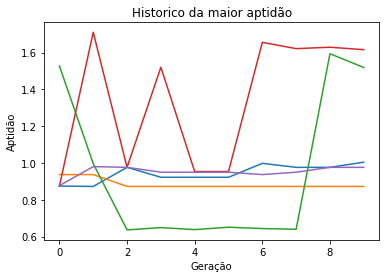

In [5]:
for i in range(0, runs):
    plt.plot(allJ[i, :])
    plt.title("Historico da maior aptidão")
plt.xlabel("Geração")
plt.ylabel("Aptidão")
plt.show()

In [7]:
OH = OceanHelper('./OceanScripts/', 'x_template.ocn')
OH.create_population(1)
bestX = allX[np.argmax(allS), :]
OH.update_x(bestX, 0)
OH.compute_fitness(0, target)
vout = OH.read_response("vout", 0)
vin = OH.read_response("vin", 0)
vcomp = OH.read_response("vcomp", 0)

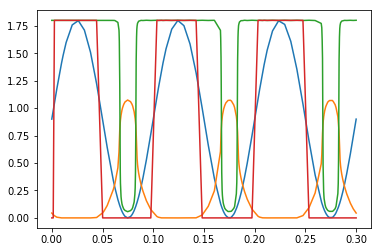

In [8]:
plt.plot(vin[:, 0], vin[:, 1])
plt.plot(vcomp[:, 0], vcomp[:, 1])
target_wave = (vin[:, 1] > target)*1.8
plt.plot(vout[:, 0], vout[:, 1])
plt.plot(vout[:, 0], target_wave)
plt.show();